In [6]:
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import os
import missingno as msno
import seaborn as sns
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [7]:
# checking the current directory
os.getcwd()

'/Users/yg/insight/github/data_challenges/BreastCancerDetection'

## Breast Cancer Detection

* Business Objectives:
    1. What features of a cell are the largest drivers of malignancy?

    2. How would a physician use your product?

    3. There is a non-zero cost in time and money to collect each feature about a given cell. How would you go about determining the most cost-effective method of detecting malignancy?


# Wrangle
## Read in the data

In [144]:
df = pd.read_csv('breast-cancer-wisconsin-2.csv')
print('Number of rows:',len(df))
df.head()

Number of rows: 15854


,0,1241035,7,8,3,7.1,4,5,7.2,8.1,2,4.1
0,1,1107684,6,10,5,5,4,10,6,10,1,4
1,2,691628,8,6,4,10,10,1,3,5,1,4
2,3,1226612,7,5,6,3,3,8,7,4,1,4
3,4,1142706,5,10,10,10,6,10,6,5,2,4
4,5,601265,10,4,4,6,2,10,2,3,1,4


In [145]:
df.dtypes

0           int64
1241035     int64
7           int64
8          object
3          object
7.1        object
4          object
5          object
7.2        object
8.1        object
2          object
4.1        object
dtype: object

Create meaningful column labels

In [146]:
df.columns = ['cell','sample_id','clump_thickness','uniformity_size','uniformity_shape',
             'marginal_adhesion','single_cell_size','bare_nuclei','bland chromatin',
             'normal_nucleoli','mitoses','class']

Check the different columsn to get an idea of what strings might be included and how many occurences

In [147]:
df['mitoses'].value_counts()

1          10527
2           4012
7           1004
10           118
20            36
3             33
?             23
No idea       17
70            16
4             12
#             11
8              8
5              6
6              3
Name: mitoses, dtype: int64

In [148]:
def compute_number_rows(df, column_name, value):
    matched_value_df = df.loc[df[column_name] == value]
    percents = (matched_value_df[column_name].count()/df[column_name].count()) * 100
    print('% of matching rows={} for value={}'.format(percents, value))

def drop_rows(df, column_name, value):
    indexNames = df[df[column_name] == value].index
    n1 = len(df)
    df.drop(indexNames , inplace=True)
    print('Number of dropped rows:{}'.format(n1 - len(df)))

In [149]:
compute_number_rows(df, 'class', 'No idea')

% of matching rows=0.10741817262732213 for value=No idea


After checking all columns in this manner, the observations that aren't numbers 1-10 are a small fraction of the data set and likely can be safely removed

In [150]:
# convert to numeric, all strings become nans
df_num = df.copy()
for col in df:
    df_num[col] = pd.to_numeric(df_num[col], errors='coerce')
df_num.dtypes

cell                   int64
sample_id              int64
clump_thickness        int64
uniformity_size      float64
uniformity_shape     float64
marginal_adhesion    float64
single_cell_size     float64
bare_nuclei          float64
bland chromatin      float64
normal_nucleoli      float64
mitoses              float64
class                float64
dtype: object

In [151]:
df_num['mitoses'].value_counts()

1.0     10527
2.0      4012
7.0      1004
10.0      118
20.0       36
3.0        33
70.0       16
4.0        12
8.0         8
5.0         6
6.0         3
Name: mitoses, dtype: int64

We notice that some of the values are outside of the range 0-10, convert them to nan so we can check how many we will drop 
in a dropna action.

In [152]:
cols_to_apply = df_num.columns[2:-1]
cols_to_apply

Index(['clump_thickness', 'uniformity_size', 'uniformity_shape',
       'marginal_adhesion', 'single_cell_size', 'bare_nuclei',
       'bland chromatin', 'normal_nucleoli', 'mitoses'],
      dtype='object')

In [153]:
for col in cols_to_apply:
    df_num[col] = df_num[col].apply(lambda x: np.nan if x < 1 or x > 10 else x)

In [154]:
df_num['mitoses'].value_counts()

1.0     10527
2.0      4012
7.0      1004
10.0      118
3.0        33
4.0        12
8.0         8
5.0         6
6.0         3
Name: mitoses, dtype: int64

In [155]:
df_num['class'].value_counts()

4.0     15163
2.0       456
40.0      151
20.0        5
Name: class, dtype: int64

In [156]:
df_num['class'] = df_num['class'].apply(lambda x: np.nan if x == 20 or x == 40 else x)

Now that looks good. We can use missingno to examine the set of nan values we are considering dropping from the dataset

In [157]:
# checking missing data in data 
total = df_num.isnull().sum().sort_values(ascending = False)
percent = (df_num.isnull().sum()/df_num.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
class,235,1.482276
single_cell_size,235,1.482276
bland chromatin,234,1.475968
bare_nuclei,234,1.475968
uniformity_size,232,1.463353


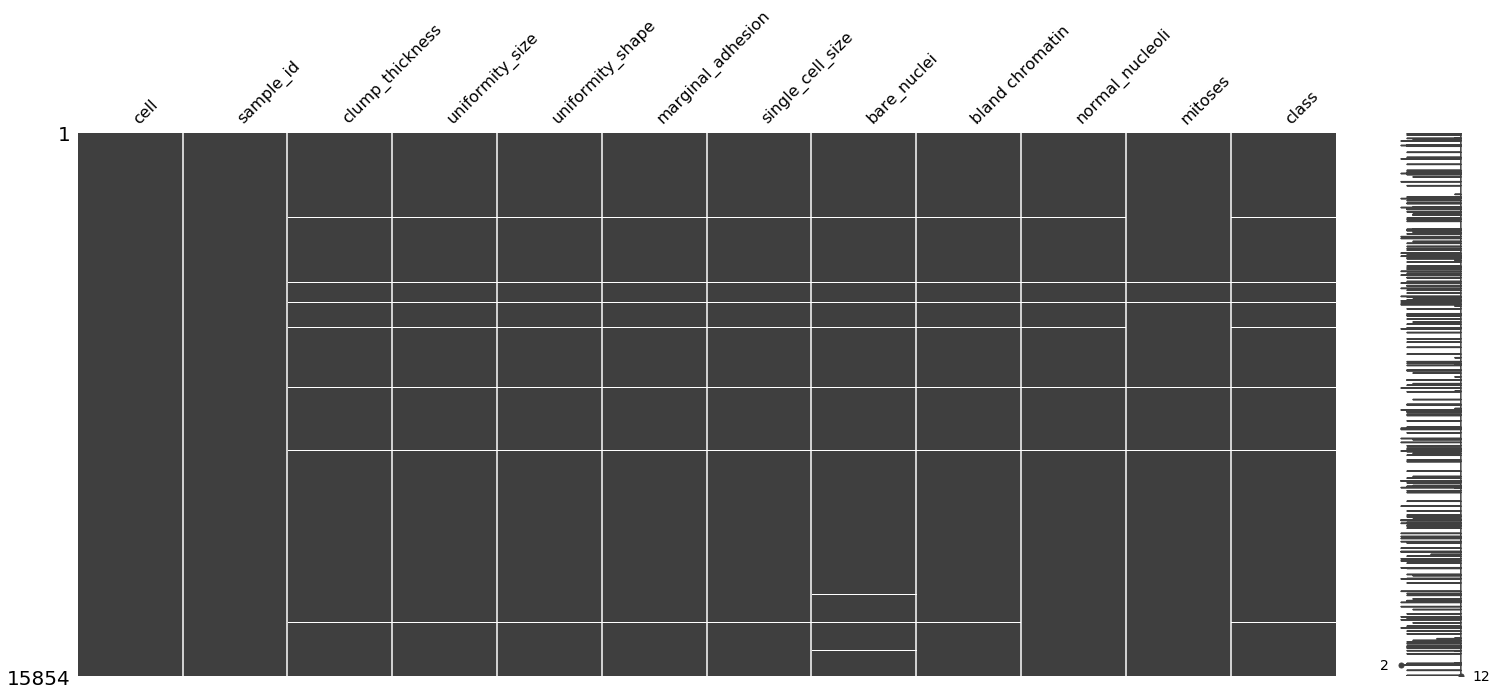

In [158]:
msno.matrix(df_num)

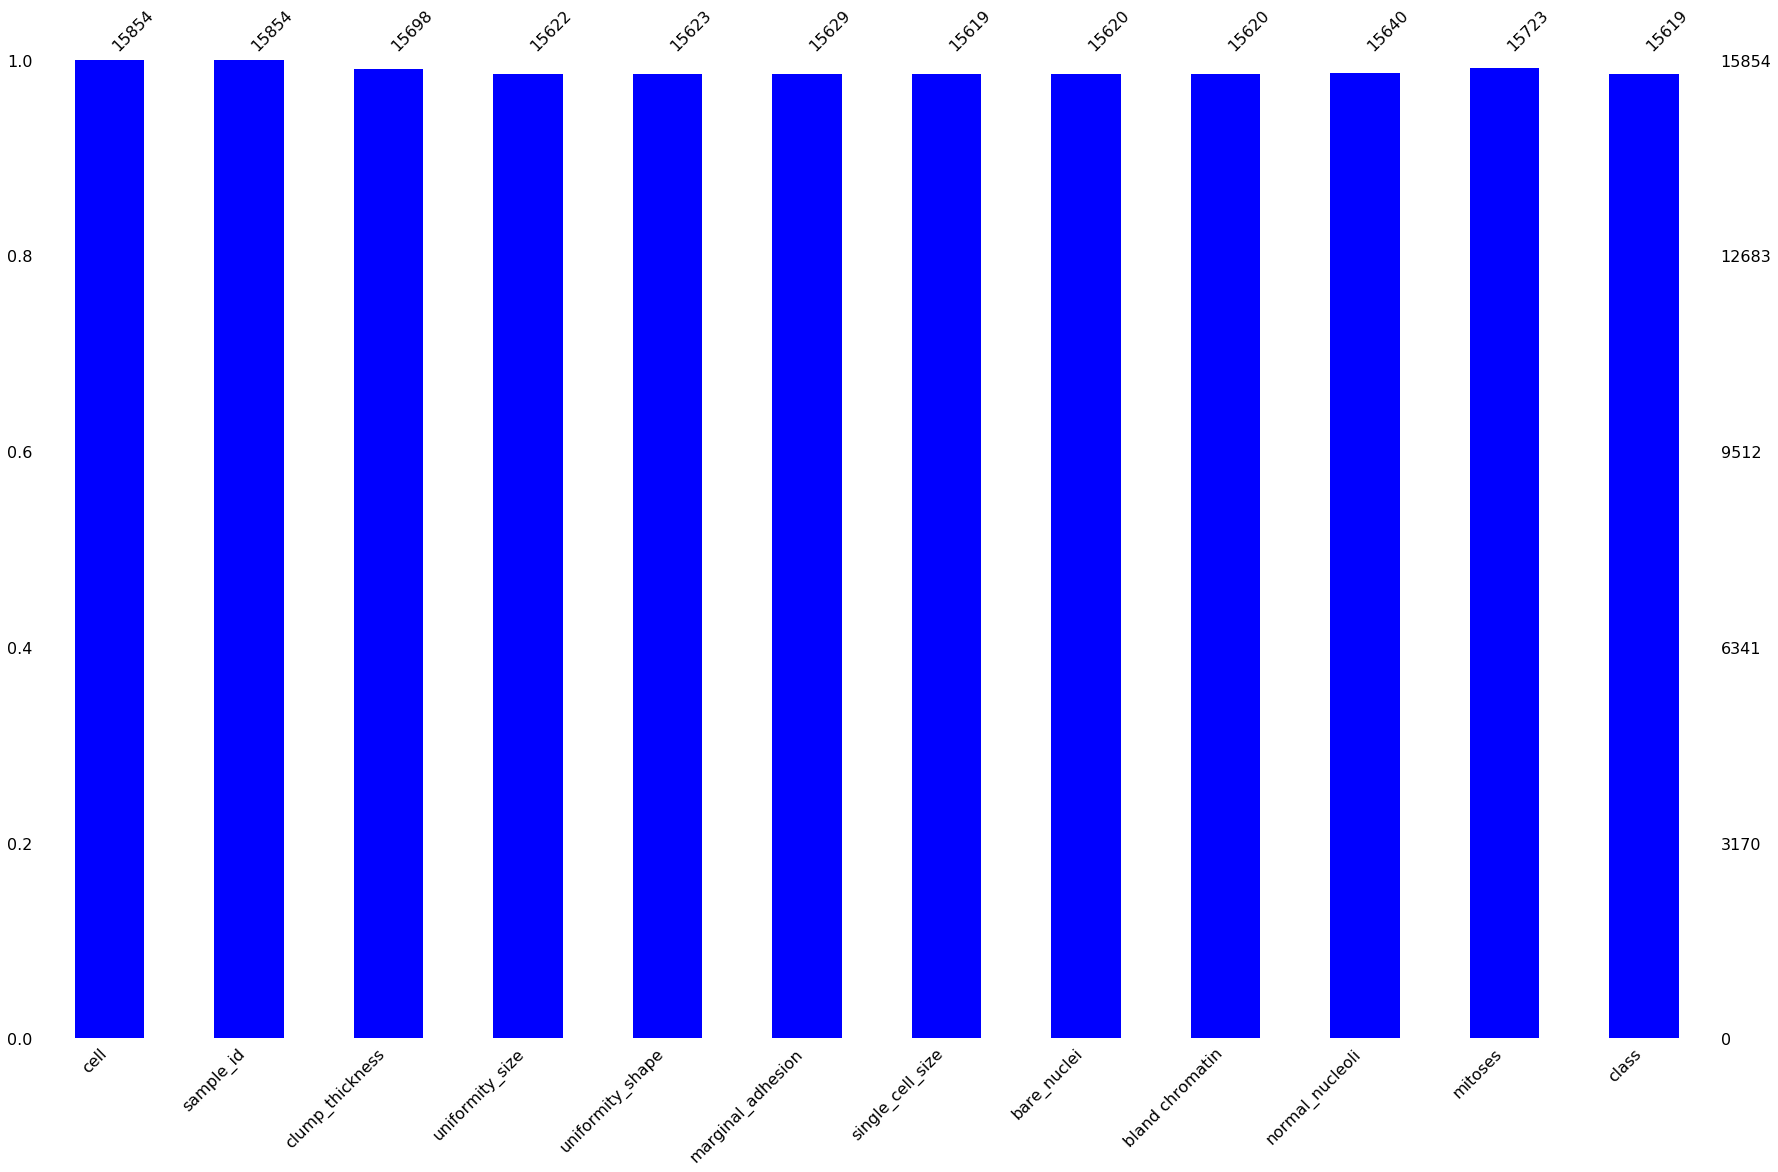

In [159]:
msno.bar(df_num, color="blue", figsize=(30,18))

Most of the data is not missing so we can drop the nan values.

In [160]:
df_clean = df_num.dropna()

In [163]:
# Let's replace the Class by a boolean (True is malignant)
df_clean['malignant'] = False
df_clean['malignant'][df_clean['class']==4.]=True

In [164]:
df_clean.head()

,cell,sample_id,clump_thickness,uniformity_size,uniformity_shape,marginal_adhesion,single_cell_size,bare_nuclei,bland chromatin,normal_nucleoli,mitoses,class,malignant
0,1,1107684,6.0,10.0,5.0,5.0,4.0,10.0,6.0,10.0,1.0,4.0,True
1,2,691628,8.0,6.0,4.0,10.0,10.0,1.0,3.0,5.0,1.0,4.0,True
2,3,1226612,7.0,5.0,6.0,3.0,3.0,8.0,7.0,4.0,1.0,4.0,True
3,4,1142706,5.0,10.0,10.0,10.0,6.0,10.0,6.0,5.0,2.0,4.0,True
4,5,601265,10.0,4.0,4.0,6.0,2.0,10.0,2.0,3.0,1.0,4.0,True


# EDA

Looking at distributions of features and correlation between features

In [165]:
cols_to_apply = df_num.columns[2:-1]

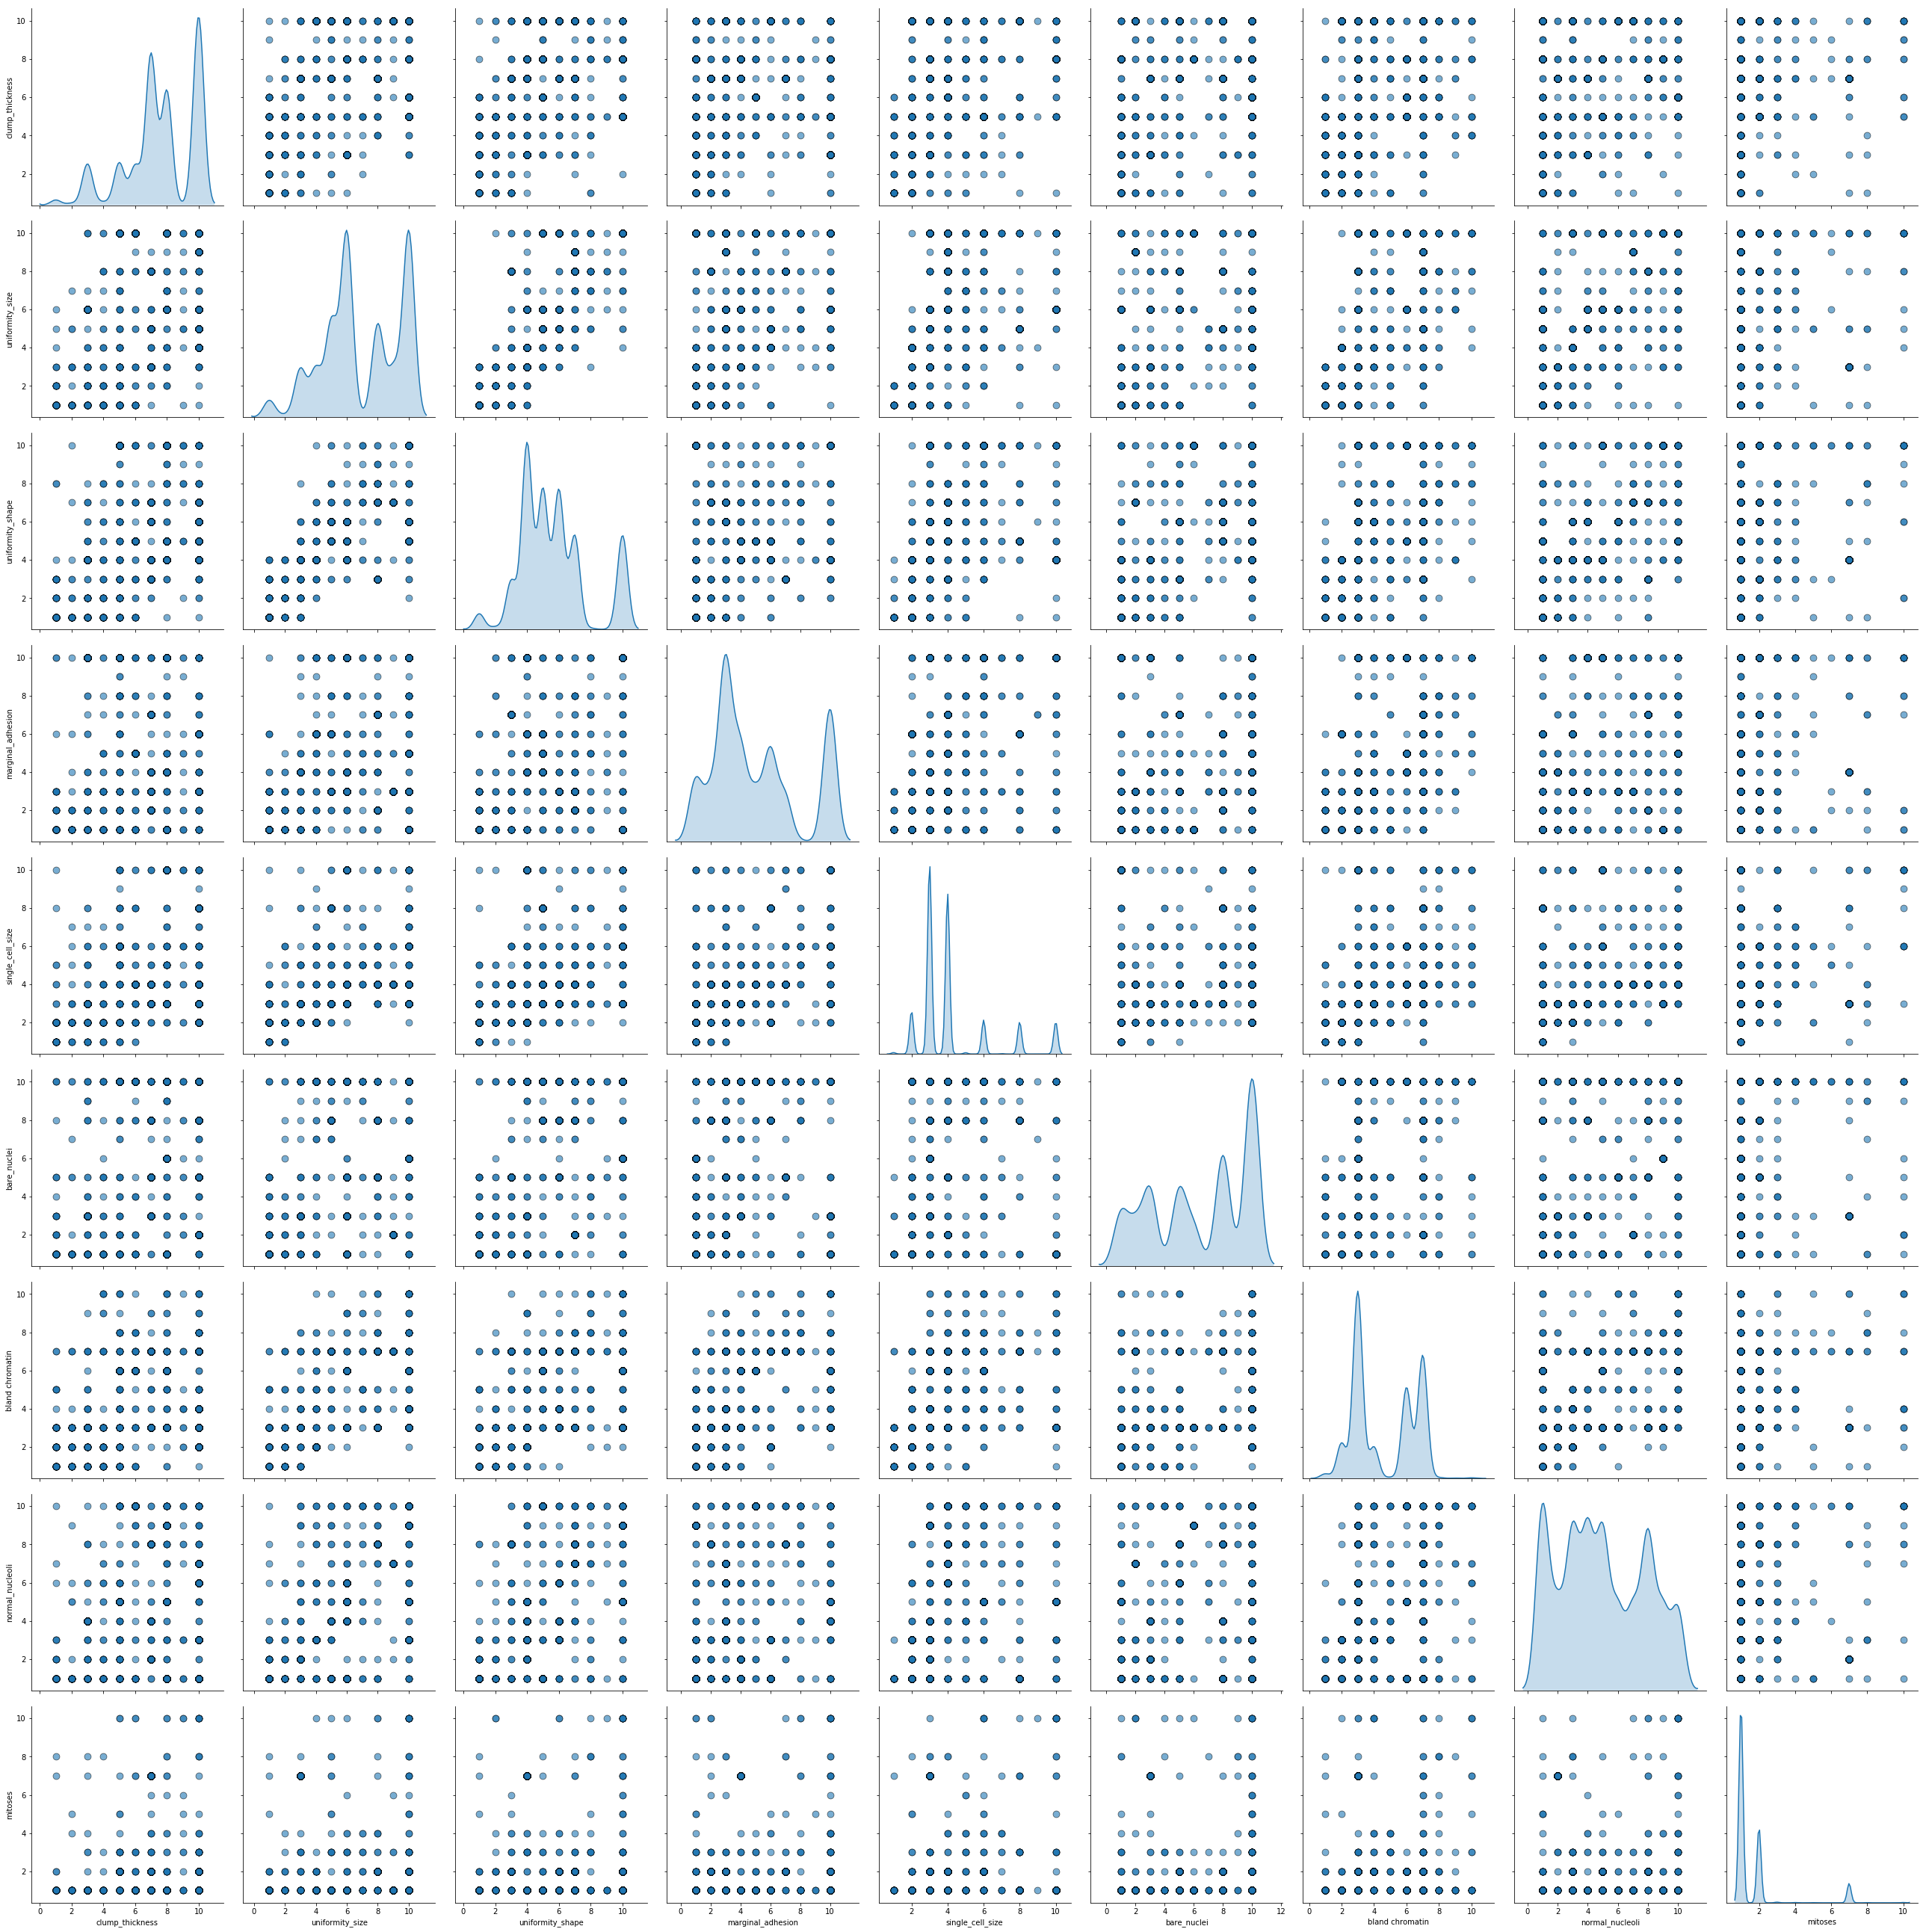

In [28]:
sns.pairplot(df_clean[cols_to_apply], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4)

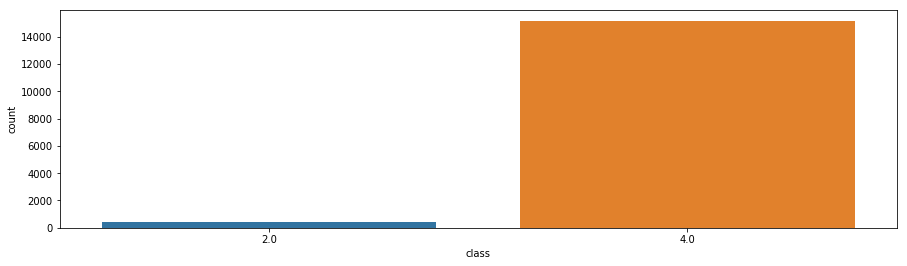

In [166]:
plt.figure(figsize=(15,4))
sns.countplot(df_clean['class'])

The target class is imbalanced.

In [167]:
# Since we're trying see what features predict malignancy, let's see how imbalanced the 'Class' column is
df_clean['class'].value_counts()

4.0    15161
2.0      442
Name: class, dtype: int64

# 30+ times cells more malignant than benign

In [168]:
df_clean.malignant.unique()

array([ True, False])

In [169]:
cleaned_df = df_clean.drop_duplicates('sample_id')

In [170]:
cleaned_df['class'].value_counts()

2.0    396
4.0    232
Name: class, dtype: int64

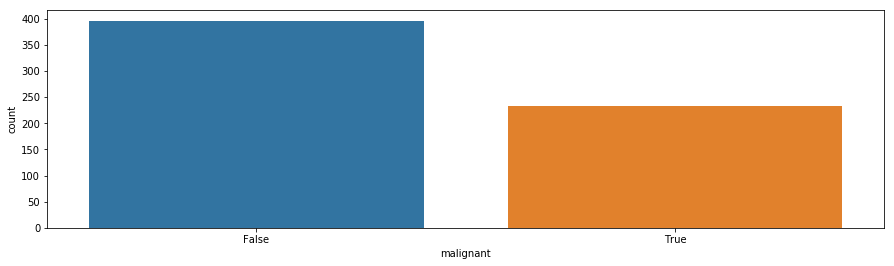

In [171]:
plt.figure(figsize=(15,4))
sns.countplot(cleaned_df['malignant']);

The data set is still imbalanced but with less difference.

In [172]:
cleaned_df.columns

Index(['cell', 'sample_id', 'clump_thickness', 'uniformity_size',
       'uniformity_shape', 'marginal_adhesion', 'single_cell_size',
       'bare_nuclei', 'bland chromatin', 'normal_nucleoli', 'mitoses', 'class',
       'malignant'],
      dtype='object')

In [173]:
cols_to_apply = cleaned_df.columns[2:-2]
cols_to_apply

Index(['clump_thickness', 'uniformity_size', 'uniformity_shape',
       'marginal_adhesion', 'single_cell_size', 'bare_nuclei',
       'bland chromatin', 'normal_nucleoli', 'mitoses'],
      dtype='object')

In [174]:
mean_dict = defaultdict(dict)
for column in cols_to_apply:
    for mal in [True,False]:
        mean_dict[column][mal] = cleaned_df[cleaned_df.malignant==mal][column].mean()
    

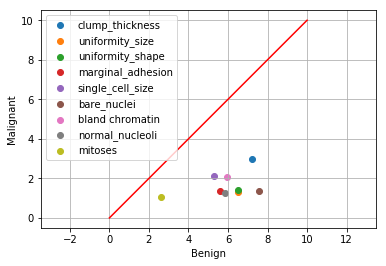

In [175]:
fig, ax = plt.subplots()
ax.plot([0,10],[0,10],'-r')
for column in cols_to_apply:
    ax.scatter(mean_dict[column][True],mean_dict[column][False],label=column)
ax.legend()
plt.xlabel('Benign')
plt.ylabel('Malignant')
ax.axis('equal')
ax.grid(True)

At first sight, mitoses will be a bad predictor.
let's look at the distributions.

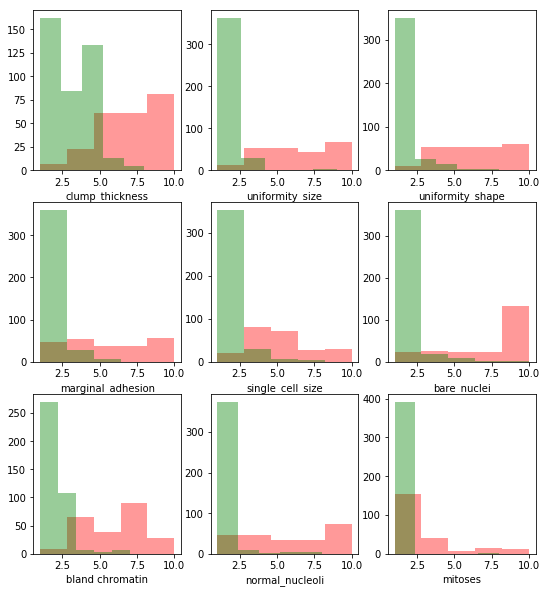

In [176]:
n_columns = len(cols_to_apply)
fig, axs = plt.subplots(3, 3, figsize=(9,10))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for ax_index, column in enumerate(cols_to_apply):
    sns.distplot(cleaned_df[cleaned_df.malignant==True][column], hist=True, kde=False, color='r', bins=5, ax=axs[ax_index])    
    sns.distplot(cleaned_df[cleaned_df.malignant==False][column], hist=True, kde=False, color='g',
                 bins=5, ax=axs[ax_index])

# Separation between malignant and benign is very good.

## Principal Component Analysis

In [177]:
feature_names = cleaned_df.columns[2:-2]
feature_names

Index(['clump_thickness', 'uniformity_size', 'uniformity_shape',
       'marginal_adhesion', 'single_cell_size', 'bare_nuclei',
       'bland chromatin', 'normal_nucleoli', 'mitoses'],
      dtype='object')

In [178]:
features = cleaned_df[feature_names]
features_scaled = StandardScaler().fit_transform(features)

In [179]:
pca = PCA(n_components=2)

principal_components = pca.fit_transform(features_scaled)

principal_dataframe = pd.DataFrame(data=principal_components,
                                  columns=['component 1', 'component 2'])

principal_dataframe_labeled = pd.concat([principal_dataframe,
                                         cleaned_df[['malignant']]],
                                         axis=1)

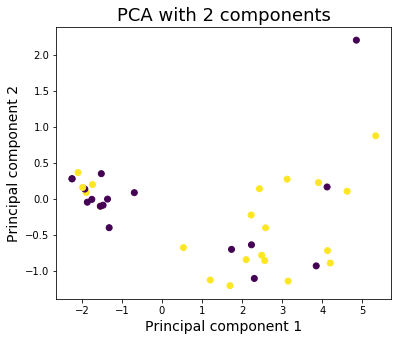

In [180]:
plt.figure(figsize=(6,5))

plt.scatter(principal_dataframe_labeled['component 1'],
           principal_dataframe_labeled['component 2'],
           c = principal_dataframe_labeled['malignant'],
           cmap = 'viridis')

plt.xlabel('Principal component 1', fontsize=14)
plt.ylabel('Principal component 2', fontsize=14)

plt.title('PCA with 2 components', fontsize=18);

In [181]:
print('Principal Component 1: {:0.2f}%'\
          .format(100 * pca.explained_variance_ratio_[0]))
print('Principal Component 2: {:0.2f}%'\
          .format(100 * pca.explained_variance_ratio_[1]))

Principal Component 1: 65.01%
Principal Component 2: 8.81%


# Modeling

We need to provide answers to these questions:
    
1. What features of a cell are the largest drivers of malignancy?
We need to find the feature importance in classifying the celss as being malign or not.

2. How would a physician use your product?
Doctors have to be able to explain their decisions to patients, insurance providers and lawyers.
Interpretable models are preferrred. 

3. There is a non-zero cost in time and money to collect each feature about a given cell. 
How would you go about determining the most cost-effective method of detecting malignancy?

In [182]:
cols_to_apply = cleaned_df.columns[2:-2]
cols_to_apply

Index(['clump_thickness', 'uniformity_size', 'uniformity_shape',
       'marginal_adhesion', 'single_cell_size', 'bare_nuclei',
       'bland chromatin', 'normal_nucleoli', 'mitoses'],
      dtype='object')

In [183]:
x_train, x_test, y_train, y_test = train_test_split(
        cleaned_df[cols_to_apply].values,
        cleaned_df.malignant.values,
        test_size=0.3,
    )                 

In [184]:
#compare value count of original data
print('Training size:', x_train.shape[0])
print('Test size:', x_test.shape[0])

Training size: 439
Test size: 189


In [185]:
#random forest classifier 
rf = RandomForestClassifier()      
rf = rf.fit(x_train,y_train)

Accuracy is:  0.9735449735449735
F1 Score is:  0.9612403100775193


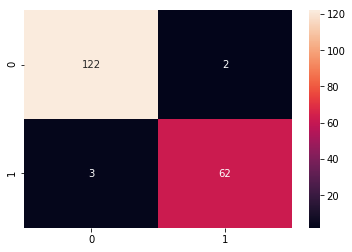

In [186]:
y_prediction = rf.predict(x_test)
ac = accuracy_score(y_test, y_prediction)
print('Accuracy is: ',ac)
f1 = f1_score(y_test, y_prediction)
print('F1 Score is: ', f1)
cm = confusion_matrix(y_test, y_prediction)
sns.heatmap(cm,annot=True,fmt="d")

Pretty good out of the box.

In [187]:
# feature importances
for feature_name, val in zip(cols_to_apply, rf.feature_importances_):
    print("{}: {:.2f}%".format(feature_name,val))

clump_thickness: 0.05%
uniformity_size: 0.20%
uniformity_shape: 0.32%
marginal_adhesion: 0.08%
single_cell_size: 0.03%
bare_nuclei: 0.13%
bland chromatin: 0.09%
normal_nucleoli: 0.08%
mitoses: 0.01%


We can probably use only the top two or three features.

In [188]:
top_features = ['uniformity_size', 'bare_nuclei','uniformity_shape']              

In [189]:
x_train, x_test, y_train, y_test = train_test_split(
        cleaned_df[top_features].values,
        cleaned_df.malignant.values,
        test_size=0.3,
    )

In [190]:
#random forest classifier 
rf = RandomForestClassifier()      
rf = rf.fit(x_train,y_train)

Accuracy is:  0.9312169312169312
F1 Score is:  0.9037037037037037


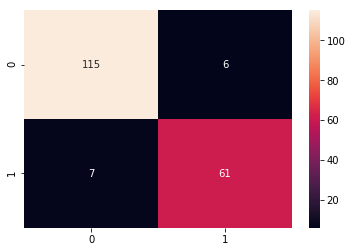

In [191]:
y_prediction = rf.predict(x_test)
ac = accuracy_score(y_test, y_prediction)
print('Accuracy is: ',ac)
f1 = f1_score(y_test, y_prediction)
print('F1 Score is: ', f1)
cm = confusion_matrix(y_test, y_prediction)
sns.heatmap(cm,annot=True,fmt="d");

We see that using just three features, we still were able to do quite well, with over  92%  accuracy and F1 score is of the same order. 
Thus, we can supply only three features to our predictions and still do quite well.

# Another modelisation

As we are working with doctors, who typically come from non-data backgrounds, 
it's important that your model is highly interpretable. 
Thus, we will start by trying Logistic Regression for classification.

In [192]:
cols_to_apply = cleaned_df.columns[2:-2]
cols_to_apply

Index(['clump_thickness', 'uniformity_size', 'uniformity_shape',
       'marginal_adhesion', 'single_cell_size', 'bare_nuclei',
       'bland chromatin', 'normal_nucleoli', 'mitoses'],
      dtype='object')

In [193]:
# Split into training and test sets
X = cleaned_df[cols_to_apply]
y = cleaned_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print('Training size:', x_train.shape[0])
print('Test size:', x_test.shape[0])

Training size: 439
Test size: 189


In [194]:
# Create classifier
clf = LogisticRegression(class_weight='balanced')

# Train model
clf.fit(X_train, y_train)

# Get predicted probabilities
y_score = clf.predict_proba(X_test)[:,1]
y_pred = clf.fit(X_train, y_train).predict(X_test)

Accuracy is:  0.9841269841269841
F1 Score is:  0.9841019849803205


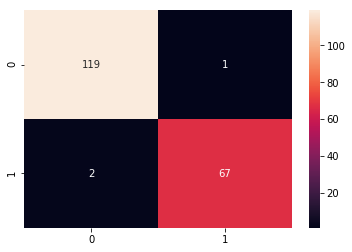

In [195]:
ac = accuracy_score(y_test.values, y_pred)
print('Accuracy is: ',ac)
f1 = f1_score(y_test.values, y_pred, average='weighted')
print('F1 Score is: ', f1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True, fmt="d");

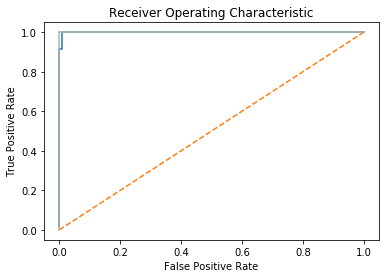

In [196]:
# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score, pos_label=4)

# Plot ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [197]:
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)
coefficients.columns = ['feature','coefficients']
coefficients.sort_values('coefficients',ascending=False)

,feature,coefficients
5,bare_nuclei,0.381184
0,clump_thickness,0.270455
3,marginal_adhesion,0.201491
1,uniformity_size,0.189225
2,uniformity_shape,0.173133
7,normal_nucleoli,0.155883
8,mitoses,0.155534
6,bland chromatin,0.082519
4,single_cell_size,-0.031725


With a Logistic Regression model on just the features: 'bare nuclei', 'Clump Thickness', 'marginal adhesion'
the classifier performs well and lowers the required number of features to check from 9 to 3.
However, we  have false negatives (predicting benign when actually malignant). 
Thus, doctors will need to be extra careful when using this model.